In [1]:
# Load bible data and create a dataframe from the pkl
import pandas as pd
import numpy as np

In [2]:

df = pd.read_pickle('bible_df.pkl')
# Print out the column names
print(df.columns)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Verse ID', 'Book Name', 'Book Number',
       'Chapter', 'Verse', 'Text', 'Embedding'],
      dtype='object')


In [3]:
# Load the bible into Chroma - use the default embeddings
import chromadb
from chromadb.config import Settings

# Create a client, and create a collection
collection_name = 'the_bible'
persist_directory = 'chroma'

client = chromadb.Client(Settings(persist_directory=persist_directory, chroma_db_impl="duckdb+parquet"))
collection = client.create_collection(collection_name)

# Add the bible to the collection - Chroma will embed it for you

chapters = df['Chapter'].tolist()
books = df['Book Name'].tolist()
verses = df['Verse'].tolist()

collection.add(
    ids = [str(id) for id in df['Verse ID'].tolist()],
    embeddings=df['Embedding'].tolist(),
    documents=df['Text'].tolist(),
    metadatas=[{"chapter": chapter, "book": book, "verse": verse} for chapter, book, verse in zip(chapters, books, verses)]
)

client.persist()
del client

Running Chroma using direct local API.
No existing DB found in chroma, skipping load
No existing DB found in chroma, skipping load


/Users/antontroynikov/miniforge3/envs/hackathon_demo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Persisting DB to disk, putting it in the save folder chroma


True

In [4]:
items = collection.get()

embeddings = items['embeddings']
books = [metadata['book'] for metadata in items['metadatas']]

print(len(embeddings))

31102


<AxesSubplot:>

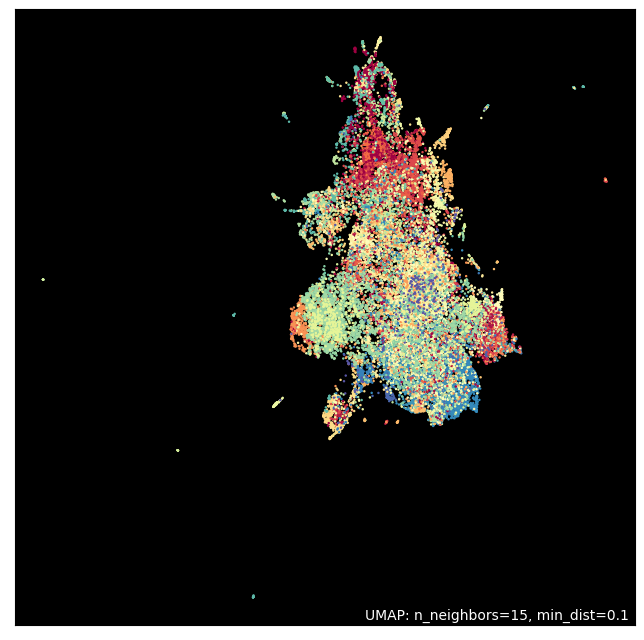

In [5]:
# Project the bible embeddings to 2D using UMAP
import umap
import umap.plot

mapper = umap.UMAP().fit(embeddings)

umap.plot.points(mapper, labels=np.array(books), background='black', show_legend=False)


In [8]:
# Let's ask God some questions
from langchain.vectorstores import Chroma
from langchain.chains import VectorDBQAWithSourcesChain
from langchain import OpenAI

collection_name = 'the_bible'
persist_directory = 'chroma'

# Read in the oepnai api key from openai.key
openai_api_key = open('openai.key', 'r').read()

docsearch = Chroma(collection_name=collection_name, persist_directory=persist_directory)
chain = VectorDBQAWithSourcesChain.from_chain_type(OpenAI(temperature=0, openai_api_key=openai_api_key), chain_type="stuff", vectorstore=docsearch)

chain({"question": "What is the greatest good?"}, return_only_outputs=True)

Running Chroma using direct local API.
loaded in 31102 embeddings
loaded in 1 collections


NoIndexException: Index is not initialized